In [2]:
import os, dotenv

dotenv.load_dotenv()

os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["COMPOSIO_API_KEY"] = os.getenv("COMPOSIO_API_KEY")

In [24]:
from langchain_google_genai import  ChatGoogleGenerativeAI

from langgraph_supervisor import create_supervisor
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver

model = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")

# Create specialized agents

def add(a: float, b: float) -> float:
    """Add two numbers."""
    return a + b

def multiply(a: float, b: float) -> float:
    """Multiply two numbers."""
    return a * b

def web_search(query: str) -> str:
    """Search the web for information."""
    return (
        "Here are the headcounts for each of the FAANG companies in 2024:\n"
        "1. **Facebook (Meta)**: 67,317 employees.\n"
        "2. **Apple**: 164,000 employees.\n"
        "3. **Amazon**: 1,551,000 employees.\n"
        "4. **Netflix**: 14,000 employees.\n"
        "5. **Google (Alphabet)**: 181,269 employees."
    )

math_agent = create_react_agent(
    model=model,
    tools=[add, multiply],
    name="math_expert",
    prompt="You are a math expert. Always use one tool at a time."
)

research_agent = create_react_agent(
    model=model,
    tools=[web_search],
    name="research_expert",
    prompt="You are a world class researcher with access to web search. Do not do any math."
)

# Create supervisor workflow
workflow = create_supervisor(
    [research_agent, math_agent],
    model=model,
    output_mode="full_history",
    prompt="""You are a team supervisor managing a research expert and a math expert. You can transfer the task to these agents.
    If you can't directly answer user query, delegate the task to the most suitable agent.""",
)

# Compile and run
app = workflow.compile(checkpointer=MemorySaver())


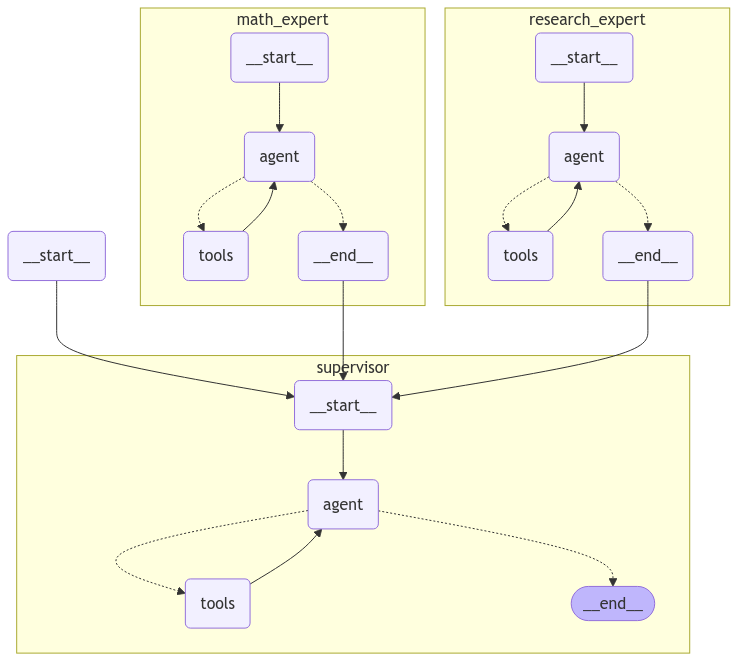

In [26]:
from IPython.display import Image, display
display(Image(app.get_graph(xray=1).draw_mermaid_png()))

In [30]:
config = {"configurable": {"thread_id": "1"}}
res = app.invoke({
    "messages": [
        {
            "role": "user",
            "content": "Hi"
        }
    ]
}, config)

In [35]:
app.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='4efc4433-b14a-40a7-a0cc-af7acfd7ef4c'), AIMessage(content='Hi, how can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, name='supervisor', id='run-ec6c59e4-4d84-4bad-aef0-c38ae3f91f94-0', usage_metadata={'input_tokens': 71, 'output_tokens': 10, 'total_tokens': 81, 'input_token_details': {'cache_read': 0}})]}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efe7d2f-7b88-6921-8001-19f6963c9a07'}}, metadata={'source': 'loop', 'writes': {'supervisor': {'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='4efc4433-b14a-40a7-a0cc-af7acfd7ef4c'), AIMessage(content='Hi, how can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_rati

In [36]:
app.invoke({
    "messages": [
        {
            "role": "user",
            "content": "calculate 5 + 2 * 3"
        }
    ]
}, config)

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='4efc4433-b14a-40a7-a0cc-af7acfd7ef4c'),
  AIMessage(content='Hi, how can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, name='supervisor', id='run-ec6c59e4-4d84-4bad-aef0-c38ae3f91f94-0', usage_metadata={'input_tokens': 71, 'output_tokens': 10, 'total_tokens': 81, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='calculate 5 + 2 * 3', additional_kwargs={}, response_metadata={}, id='904dfd8b-e2dd-4d21-9f29-30cefe081467'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'transfer_to_math_expert', 'arguments': '{}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, name='supervisor', id='run-666cfc64-e4ee-4372-a888-bd9576965b17-0', tool_calls=[{'name': 'transfer